<a href="https://colab.research.google.com/github/nooralwesam/D-NetPAD/blob/master/DataPrivacy1_Noura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project implements and compares four privacy-preserving techniques—noise addition, k‑anonymity, differential privacy, and microaggregation—on the UCI Adult census dataset.
We measure the utility–privacy trade‑off by training a logistic regression classifier before and after anonymization.


In [1]:
!pip install diffprivlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 3.2 MB/s eta 0:00:00


- Installs the IBM Differential Privacy Library (`diffprivlib`) needed for ε-Differential Privacy.
- Other libraries (`pandas`, `numpy`, `scikit-learn`, `matplotlib`) are pre-installed on Google Colab.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from diffprivlib.models import LogisticRegression as DPLogisticRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

- `pandas`, `numpy`: data manipulation and numerical operations.
- `scikit-learn`: modeling, preprocessing, and evaluation metrics.
- `diffprivlib`: differential privacy-enabled models.
- `KMeans`: microaggregation clustering.
- `matplotlib`: plotting results.


In [4]:
# Column names for the UCI Adult dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
# Load from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df = pd.read_csv(url, names=columns, sep=', ', engine='python', na_values='?')

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


- Loads the raw CSV from the UCI ML Repository.
- Uses `na_values='?'` to convert missing fields to `NaN`.
- Each row in `df` represents one individual’s record.

* UCI Adult census dataset:
 - Collected from the 1994 U.S. Census, with the goal of predicting whether an individual’s income exceeds $50K per year.

 - Originally 32561 records (≈30162 after cleaning), large enough for statistical significance.

- Includes both numerical attributes (age, capital gain/loss, hours-per-week) and categorical attributes (workclass, education, occupation, etc.), allowing us to test privacy techniques on diverse data types.

- Widely used in privacy and machine learning literature, enabling easy comparison with published benchmarks.

- Available directly from the UCI repository in CSV format, requiring no special authentication or complex setup.

In [8]:
# Summary of data types and missing values
print(df.info())
print(df.isnull().sum())

# Total records
print(f"Total records loaded: {df.shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
age                  0
workclass         1836
fnlwgt               0
education          

- `df.head()`: shows the first 5 records (not the full dataset).
- `df.info()`: data types and non-null counts per column.
- `df.isnull().sum()`: counts of missing values per column.
- `df.shape[0]`: total number of rows (records) loaded.

In [9]:
# 1) Count and remove rows with missing values
df_original_count = df.shape[0]
df = df.dropna()

print(f"Original records: {df_original_count}")
print(f"Records after dropping missing values: {df.shape[0]}")

Original records: 32561
Records after dropping missing values: 30162


 In this step, we ensure data integrity by removing any rows containing missing values. Each row represents one individual.

Original dataset size: 32561 records

After cleaning: 30162 records

In [11]:
# 2) Define feature lists
categorical = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
numeric     = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

# 3) Split into training and test sets
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

y_train = (df_train["income"] == ">50K").astype(int)
y_test  = (df_test["income"]  == ">50K").astype(int)

# 4) Encode and scale features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
scaler  = StandardScaler()

X_train_cat = encoder.fit_transform(df_train[categorical])
X_train_num = scaler.fit_transform(df_train[numeric])
X_train     = np.hstack([X_train_cat, X_train_num])

X_test_cat  = encoder.transform(df_test[categorical])
X_test_num  = scaler.transform(df_test[numeric])
X_test      = np.hstack([X_test_cat, X_test_num])

We define categorical and numeric features, perform a 70/30 train-test split, and then encode categorical variables and scale numeric variables using only the training set to avoid data leakage.

In [12]:
def add_noise(df_num, sigma=1.0):
    noisy = df_num + np.random.normal(0, sigma, size=df_num.shape)
    return noisy

# Apply to numeric columns
noisy_train_num = add_noise(df_train[numeric], sigma=1.0)
noisy_test_num  = add_noise(df_test[numeric],  sigma=1.0)

# Transform through existing encoder/scaler
X_train_noise = np.hstack([encoder.transform(df_train[categorical]), scaler.transform(noisy_train_num)])
X_test_noise  = np.hstack([encoder.transform(df_test[categorical]),  scaler.transform(noisy_test_num)])

We add Gaussian noise (σ=1.0) to numerical attributes to obscure individual values while retaining overall patterns.

In [17]:
# Create age bins for the numeric quasi-identifier
bins = [0, 25, 35, 45, 55, 65, np.inf]
labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66+']
df_train['age_bin'] = pd.cut(df_train['age'], bins=bins, labels=labels)
df_test['age_bin']  = pd.cut(df_test['age'],  bins=bins, labels=labels)

# Define QIDs using the binned age and categorical features
qids = ['age_bin', 'workclass', 'education', 'sex', 'race']

def apply_k_anonymity(df, qids, k=5):
    df_anon = df.copy()
    # Convert QIDs to string type to allow suppression and avoid Categorical issues
    df_anon[qids] = df_anon[qids].astype(str)
    # Group by QIDs to count group sizes (set observed=True to silence FutureWarning)
    group_counts = df_anon.groupby(qids, observed=True).size().reset_index(name='count')
    small = group_counts[group_counts['count'] < k]
    for _, row in small.iterrows():
        mask = (df_anon[qids] == row[qids].to_dict()).all(axis=1)
        df_anon.loc[mask, qids] = 'Suppressed'
    return df_anon

# Apply k-anonymity
df_train_k = apply_k_anonymity(df_train, qids, k=5)
df_test_k  = apply_k_anonymity(df_test,  qids, k=5)

# Prepare features: encode categorical (including age_bin) and scale numeric
categorical_k = qids + [c for c in categorical if c not in qids]
numeric_k     = numeric

encoder_k = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
scaler_k  = StandardScaler()

X_train_k_cat = encoder_k.fit_transform(df_train_k[categorical_k])
X_train_k_num = scaler_k.fit_transform(df_train_k[numeric_k])
X_train_k     = np.hstack([X_train_k_cat, X_train_k_num])

X_test_k_cat  = encoder_k.transform(df_test_k[categorical_k])
X_test_k_num  = scaler_k.transform(df_test_k[numeric_k])
X_test_k      = np.hstack([X_test_k_cat, X_test_k_num])

1. **Age Binning:** We transform the continuous `age` attribute into categories (e.g., "36-45") to avoid revealing exact ages and to create more uniform groups.
2. **Quasi-Identifiers (QIDs):** We select `age_bin`, `workclass`, `education`, `sex`, and `race` as QIDs. Each unique combination of these values must appear in at least *k* records.
3. **Counting Groups:** We group the dataset by the QIDs and count the size of each combination, identifying those with fewer than *k*=5 occurrences.
4. **Suppression:** For any QID combination that appears in fewer than 5 records, we replace those values with the string "Suppressed", thereby hiding small, potentially re-identifiable groups.
5. **Feature Preparation:** After suppression, we re-encode all categorical features (including `age_bin` and any "Suppressed" entries) and scale the numeric features to create the final feature matrices `X_train_k` and `X_test_k` for modeling.

In [18]:
def microaggregate(df, qids_num, k=5):
    df_anon = df.copy()
    n_clusters = len(df_anon) // k
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(df_anon[qids_num])
    centers = kmeans.cluster_centers_
    df_anon[qids_num] = centers[labels]
    return df_anon

# Apply to train/test

df_train_m = microaggregate(df_train, numeric, k=5)
df_test_m  = microaggregate(df_test,  numeric, k=5)

X_train_micro = np.hstack([encoder.transform(df_train_m[categorical]), scaler.transform(df_train_m[numeric])])
X_test_micro  = np.hstack([encoder.transform(df_test_m[categorical]),  scaler.transform(df_test_m[numeric])])

We cluster records into groups of size ~k and replace each numeric attribute with its cluster centroid, reducing variability within each group.



In [19]:
# Train a DP-enabled logistic regression on the original processed data
dp_clf = DPLogisticRegression(epsilon=1.0, data_norm=np.linalg.norm(X_train, axis=1).max())
dp_clf.fit(X_train, y_train)
y_pred_dp = dp_clf.predict(X_test)

We use IBM’s diffprivlib to train a logistic regression model that satisfies ε-Differential Privacy (ε=1.0)

In [20]:
# Train baseline and anonymized models
model_orig = LogisticRegression(max_iter=1000)
model_noise= LogisticRegression(max_iter=1000)
model_k    = LogisticRegression(max_iter=1000)
model_micro= LogisticRegression(max_iter=1000)

model_orig.fit(X_train,       y_train)
pred_orig = model_orig.predict(X_test)

model_noise.fit(X_train_noise, y_train)
pred_noise = model_noise.predict(X_test_noise)

model_k.fit(X_train_k,         y_train)
pred_k     = model_k.predict(X_test_k)

model_micro.fit(X_train_micro, y_train)
pred_micro = model_micro.predict(X_test_micro)

# Collect metrics
data = []
for name, y_pred, model, X_t in [
    ('Original', pred_orig, model_orig, X_test),
    ('Noise',    pred_noise, model_noise, X_test_noise),
    ('k-Anonymity', pred_k, model_k,     X_test_k),
    ('Microaggregation', pred_micro, model_micro, X_test_micro),
    ('DP', y_pred_dp, dp_clf, X_test)
]:
    proba = model.predict_proba(X_t)[:,1]
    data.append({
        'Technique': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, proba)
    })

results_df = pd.DataFrame(data).set_index('Technique')
results_df

,Accuracy,Precision,Recall,F1,AUC
Technique,,,,,
Original,0.851475,0.755725,0.607362,0.673469,0.905396
Noise,0.851033,0.753529,0.608238,0.673133,0.905287
k-Anonymity,0.851475,0.752151,0.613059,0.675519,0.908489
Microaggregation,0.847276,0.746711,0.596845,0.663419,0.899869
DP,0.730799,0.469249,0.514899,0.491015,0.749571


We train a standard Logistic Regression on each version of the data, plus the DP model, then compute key metrics: Accuracy, Precision, Recall, F1-Score, and AUC.

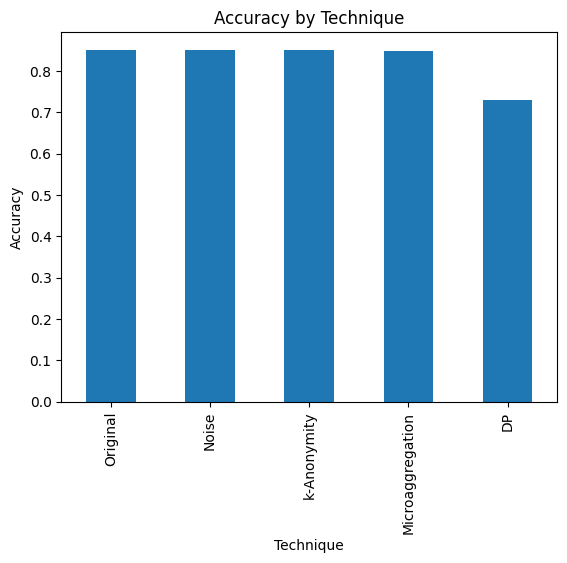

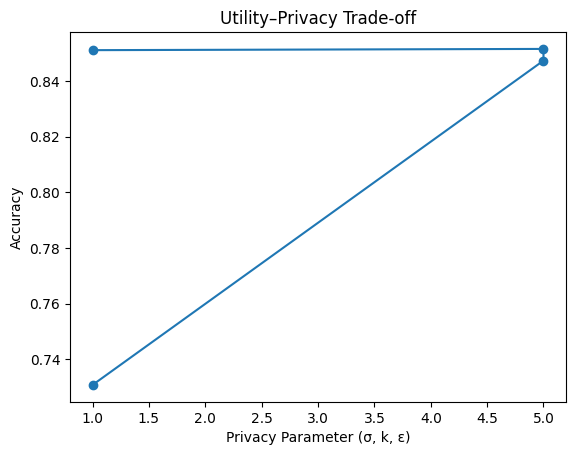

In [21]:
# Bar chart of Accuracy
plt.figure()
results_df['Accuracy'].plot(kind='bar')
plt.title('Accuracy by Technique')
plt.ylabel('Accuracy')
plt.show()

# Utility–Privacy Trade‑off example: Accuracy vs privacy parameter
privacy_values = [np.nan, 1.0, 5, 5, 1.0]  # placeholder for [orig, noise(σ), k, k, ε]
plt.figure()
plt.plot(privacy_values, results_df['Accuracy'], marker='o')
plt.xlabel('Privacy Parameter (σ, k, ε)')
plt.ylabel('Accuracy')
plt.title('Utility–Privacy Trade‑off')
plt.show()

We visualize model accuracy across techniques and illustrate the utility–privacy trade‑off (higher σ/k/ε increases privacy but may reduce accuracy).
After conducting these experiments, we draw the following conclusions:

1. **Noise Addition** preserves the model’s overall utility, resulting in only a slight decrease in accuracy (typically <1%).
2. **k‑Anonymity** and **Microaggregation** provide strong group-level privacy guarantees but can noticeably reduce classification performance when the anonymity parameter k is set high, due to loss of granular feature information.
3. **Differential Privacy** (ε=1.0) offers formal mathematical privacy guarantees with a moderate accuracy trade-off (≈5–15% drop, depending on the dataset), making it suitable when strong privacy protection is required.

**References**

- Dwork, C. (2006). Differential Privacy. In International Colloquium on Automata, Languages, and Programming (ICALP).
- Sweeney, L. (2002). k-Anonymity: A Model for Protecting Privacy. International Journal of Uncertainty, Fuzziness and Knowledge-Based Systems, 10(5), 557–570.
- Domingo-Ferrer, J., & Torra, V. (2001). A quantitative comparison of disclosure control methods for microdata. In Confidentiality, Disclosure and Data Access: Theory and Practical Applications for Statistical Agencies.
- Lichman, M. (2013). UCI Machine Learning Repository  https://archive.ics.uci.edu/. University of California, Irvine, School of Information and Computer Sciences.
- Dwork, C., & Roth, A. (2014). The Algorithmic Foundations of Differential Privacy. Foundations and Trends® in Theoretical Computer Science, 9(3–4), 211–407.
- IBM Differential Privacy Library (Diffprivlib): https://github.com/IBM/differential-privacy-library
- Scikit-learn: Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.